<a href="https://colab.research.google.com/github/andrewwells991/mds_thesis/blob/main/11_training_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Loading packages

In [ ]:
%%capture
#Loading GeoPandas
!pip install geopandas
#!pip install geemap

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Data Processing
import pandas as pd
import numpy as np

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import randint

# Modelling
from sklearn.naive_bayes import GaussianNB
from scipy.stats import uniform

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_validate, StratifiedKFold

from shapely.geometry import Point, Polygon
import geopandas as gpd
from geopandas import GeoDataFrame

##Loading full data

In [ ]:
#Labeled dataset
df = pd.read_csv('/content/gdrive/MyDrive/mds_thesis/5_labelled_data/proj_all.csv')

In [ ]:
df.columns

Index(['Unnamed: 0', 'B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'row', 'geometry',
       'index_right', 'latitude', 'longitude', 'area_in_meters', 'confidence',
       'full_plus_code', 'building', 'project', 'building_sum', 'urban_rural',
       'proj_name', 'start_date', 'end_dat', 'total_commitment',
       'total_disbursement', 'sectors', 'ieg_outcome', 'place_name'],
      dtype='object')

In [ ]:
#Drop unnecessary variable
df = df.drop(['Unnamed: 0'], axis=1)

#Model training and evaluation

###Loading un-balanced data

In [ ]:
df_train = pd.read_csv('/content/gdrive/MyDrive/mds_thesis/6_split_data/df_train.csv')
df_test = pd.read_csv('/content/gdrive/MyDrive/mds_thesis/6_split_data/df_test.csv')

In [ ]:
df_train2 = df_train[['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'building']]
df_test2 = df_test[['B2', 'B3', 'B4', 'B8', 'B11', 'B12',  'building']]

In [ ]:
X = df_train[['B2', 'B3', 'B4', 'B8', 'B11', 'B12']]

In [ ]:
#Convert 
train_np = df_train2.to_numpy()
X_train, y_train = train_np[:, :-1], train_np[:, -1]

test_np = df_test2.to_numpy()
X_test, y_test = test_np[:, :-1], test_np[:, -1]

In [ ]:
df_train.shape

(1338827, 10)

###Naive Bayes

In [ ]:
nb_std = GaussianNB()
nb_std.fit(X_train, y_train)

GaussianNB()

In [ ]:
#Evaluate
y_pred_nb_std = nb_std.predict(X_test)
print(classification_report(y_test, y_pred_nb_std))

              precision    recall  f1-score   support

         0.0       0.97      0.94      0.96    321034
         1.0       0.19      0.31      0.24     13673

    accuracy                           0.92    334707
   macro avg       0.58      0.63      0.60    334707
weighted avg       0.94      0.92      0.93    334707



###Hyperparamter standard naive Bayes

In [ ]:
param_dist = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

rand_search = RandomizedSearchCV(nb_std, 
                                 param_distributions = param_dist, 
                                 n_iter = 5, 
                                 cv = 5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

# Create a variable for the best model
hyp_nb = rand_search.best_estimator_

In [ ]:
y_pred_hyp_nb = hyp_nb.predict(X_test)
print(classification_report(y_test, y_pred_hyp_nb))

              precision    recall  f1-score   support

         0.0       0.97      0.94      0.96    321034
         1.0       0.19      0.31      0.24     13673

    accuracy                           0.92    334707
   macro avg       0.58      0.63      0.60    334707
weighted avg       0.94      0.92      0.93    334707



###Hyperparameter standard naive Bayes (recall)

In [ ]:
param_dist = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

scoring_metric = 'recall'

rand_search = RandomizedSearchCV(nb_std, 
                                 param_distributions = param_dist, 
                                 n_iter = 5, 
                                 cv = 5,
                                 scoring = scoring_metric)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

# Create a variable for the best model
hyp_recall_nb = rand_search.best_estimator_

###Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr_std = LogisticRegression(random_state=42)
lr_std.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [ ]:
#Evaluate
y_pred_lr_std = lr_std.predict(X_test)
print(classification_report(y_test, y_pred_lr_std))

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98    321034
         1.0       0.41      0.03      0.06     13673

    accuracy                           0.96    334707
   macro avg       0.68      0.52      0.52    334707
weighted avg       0.94      0.96      0.94    334707



###Hyperparameter standard logistic regression

In [ ]:
param_dist = {
    'C': uniform(0, 100),
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 500, 1000]
}

rand_search = RandomizedSearchCV(lr_std, 
                                 param_distributions = param_dist, 
                                 n_iter = 5, 
                                 cv = 5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

# Create a variable for the best model
hyp_lr = rand_search.best_estimator_

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py", line 64, in _check_solver
    raise ValueError(
ValueError: Only 'sag

In [ ]:
hyp_lr

LogisticRegression(C=45.24117155369714, max_iter=1000, random_state=42)

In [ ]:
y_pred_hyp_lr = hyp_lr.predict(X_test)
print(classification_report(y_test, y_pred_hyp_lr))

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98    321034
         1.0       0.41      0.03      0.06     13673

    accuracy                           0.96    334707
   macro avg       0.68      0.52      0.52    334707
weighted avg       0.94      0.96      0.94    334707



###Hyperparamter standard random forest

In [ ]:
#Hyperparameter check
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier(random_state= 42)

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter = 5, 
                                 cv = 5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

# Create a variable for the best model
best_rf = rand_search.best_estimator_

In [ ]:
y_pred_best_rf = best_rf.predict(X_test)
print(classification_report(y_test, y_pred_best_rf))

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98    321034
         1.0       0.65      0.09      0.16     13673

    accuracy                           0.96    334707
   macro avg       0.81      0.55      0.57    334707
weighted avg       0.95      0.96      0.95    334707



In [ ]:
best_rf

RandomForestClassifier(max_depth=16, n_estimators=108, random_state=42)

###Standard random forest

In [ ]:
rf_std = RandomForestClassifier(random_state = 42)
rf_std.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
#Evaluate
y_pred_rf_std = rf_std.predict(X_test)
print(classification_report(y_test, y_pred_rf_std))

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98    321034
         1.0       0.66      0.15      0.24     13673

    accuracy                           0.96    334707
   macro avg       0.81      0.57      0.61    334707
weighted avg       0.95      0.96      0.95    334707



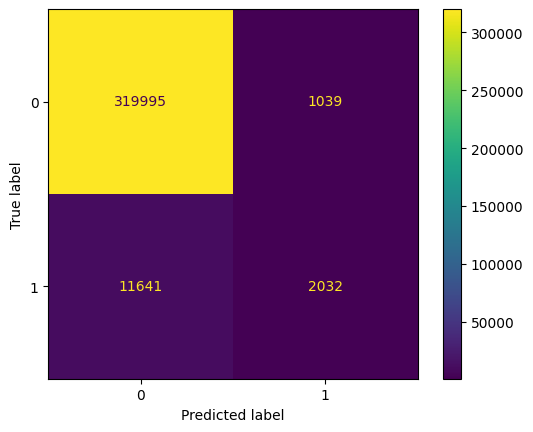

In [ ]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_rf_std)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

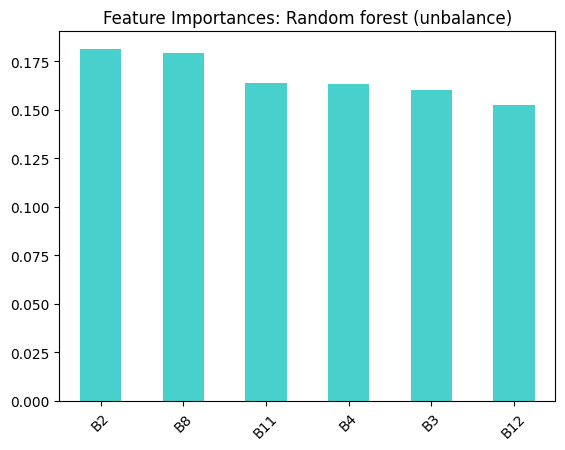

In [ ]:
# Plot the feature importances
feature_importances = pd.Series(rf_std.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', color='mediumturquoise')
plt.title('Feature Importances: Random forest (unbalance)')
plt.xticks(rotation=45)
plt.show()

###Weighted random forest

In [ ]:
rf_wgt = RandomForestClassifier(class_weight = 'balanced', random_state = 42)
rf_wgt.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
#Evaluate
y_pred_rf_wgt = rf_wgt.predict(X_test)
print(classification_report(y_test, y_pred_rf_wgt))

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98    321034
         1.0       0.72      0.11      0.20     13673

    accuracy                           0.96    334707
   macro avg       0.84      0.56      0.59    334707
weighted avg       0.95      0.96      0.95    334707



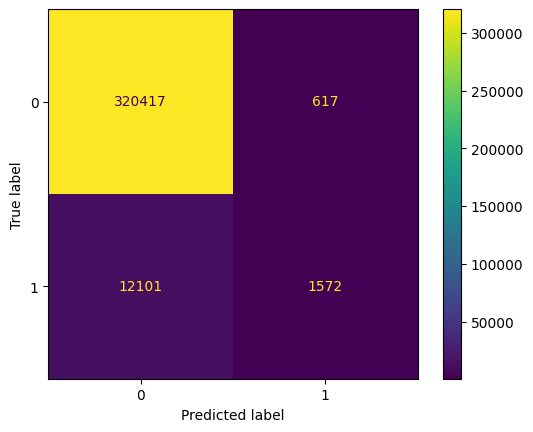

In [ ]:
# Create the confusion matrix for weight balance
cm = confusion_matrix(y_test, y_pred_rf_wgt)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

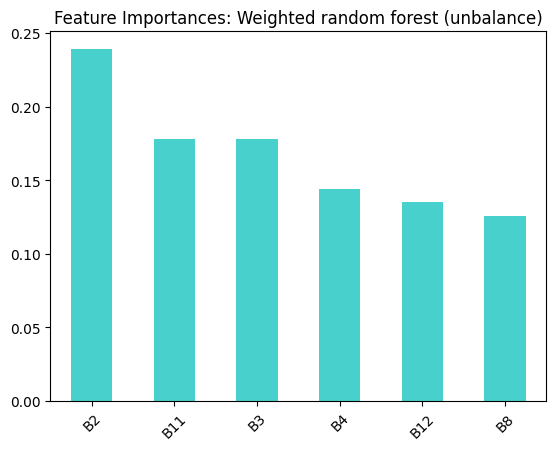

In [ ]:
# Plot the feature importances
feature_importances = pd.Series(rf_wgt.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', color='mediumturquoise')
plt.title('Feature Importances: Weighted random forest (unbalance)')
plt.xticks(rotation=45)
plt.show()

###XGBoost

In [ ]:
xgb_std = XGBClassifier(random_state = 42)
xgb_std.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [ ]:
#Evaluate
y_pred_xgb_std = xgb_std.predict(X_test)
print(classification_report(y_test, y_pred_xgb_std))

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98    321034
         1.0       0.62      0.10      0.17     13673

    accuracy                           0.96    334707
   macro avg       0.79      0.55      0.57    334707
weighted avg       0.95      0.96      0.95    334707



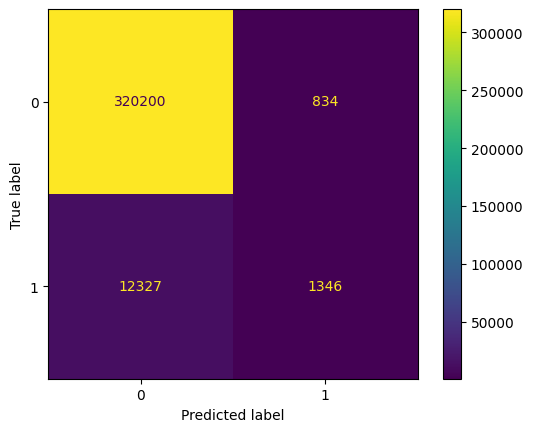

In [ ]:
# Create the confusion matrix for weight balance
cm = confusion_matrix(y_test, y_pred_xgb_std)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

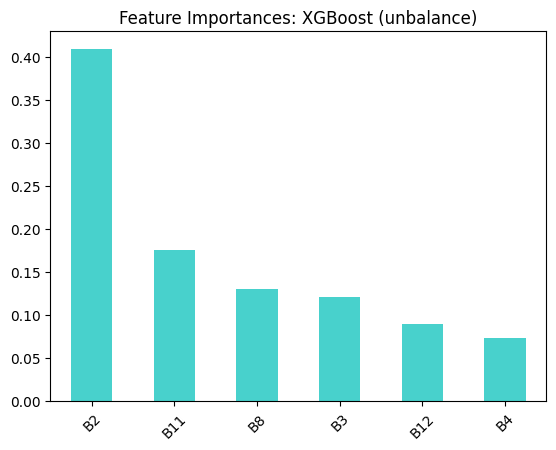

In [ ]:
# Plot the feature importances
feature_importances = pd.Series(xgb_std.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', color='mediumturquoise')
plt.title('Feature Importances: XGBoost (unbalance)')
plt.xticks(rotation=45)
plt.show()

###KNN

In [ ]:
knn_std = neighbors.KNeighborsClassifier()
knn_std.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
#Evaluate
y_pred_knn_std = knn_std.predict(X_test)
print(classification_report(y_test, y_pred_knn_std))

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98    321034
         1.0       0.45      0.15      0.22     13673

    accuracy                           0.96    334707
   macro avg       0.71      0.57      0.60    334707
weighted avg       0.94      0.96      0.95    334707



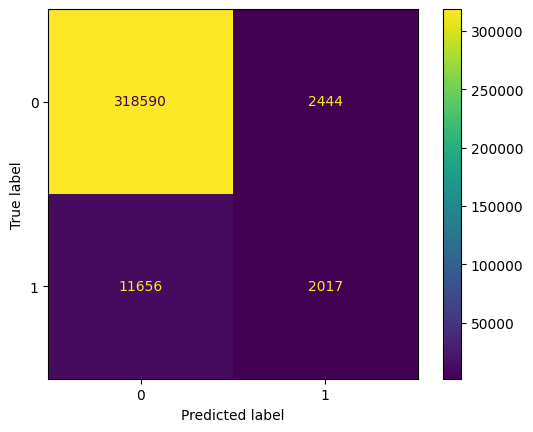

In [ ]:
# Create the confusion matrix for weight balance
cm = confusion_matrix(y_test, y_pred_knn_std)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

###Hyperparameter standard KNN

In [ ]:
param_dist = {
    'n_neighbors': randint(1, 20),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': randint(10, 100)
}

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(knn_std, 
                                 param_distributions = param_dist, 
                                 n_iter = 5, 
                                 cv = 5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

# Create a variable for the best model
hyp_knn = rand_search.best_estimator_

##Over-sampling to balance data

###Loading over-sampled dataset

In [ ]:
#Labeled dataset
df_train_over = pd.read_csv('/content/gdrive/MyDrive/mds_thesis/6_split_data/df_train_over.csv')
df_test_over = pd.read_csv('/content/gdrive/MyDrive/mds_thesis/6_split_data/df_test_over.csv')

In [ ]:
print(df_train_over.shape)
print(df_test_over.shape)

(2566841, 10)
(641711, 10)


In [ ]:
df_train_over2 = df_train_over[['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'building']]
df_test_over2 = df_test_over[['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'building']]

In [ ]:
#Convert to NumPy arrays
train_over_np = df_train_over2.to_numpy()
X_train_over, y_train_over = train_over_np[:, :-1], train_over_np[:, -1]

test_over_np = df_test_over2.to_numpy()
X_test_over, y_test_over = test_over_np[:, :-1], test_over_np[:, -1]

###Naive Bayes

In [ ]:
#Train model
nb_over = GaussianNB()
nb_over.fit(X_train_over, y_train_over)

GaussianNB()

In [ ]:
#Evaluate
y_pred_over = nb_over.predict(X_test_over)
print(classification_report(y_test_over, y_pred_over))

              precision    recall  f1-score   support

         0.0       0.67      0.81      0.73    320564
         1.0       0.76      0.59      0.67    321147

    accuracy                           0.70    641711
   macro avg       0.71      0.70      0.70    641711
weighted avg       0.71      0.70      0.70    641711



###Random forest over-sampling

In [ ]:
#Train model
rf_over = RandomForestClassifier(random_state = 42)
rf_over.fit(X_train_over, y_train_over)

RandomForestClassifier(random_state=42)

In [ ]:
#Evaluate
y_pred_over = rf_over.predict(X_test_over)
print(classification_report(y_test_over, y_pred_over))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99    320564
         1.0       0.99      1.00      0.99    321147

    accuracy                           0.99    641711
   macro avg       0.99      0.99      0.99    641711
weighted avg       0.99      0.99      0.99    641711



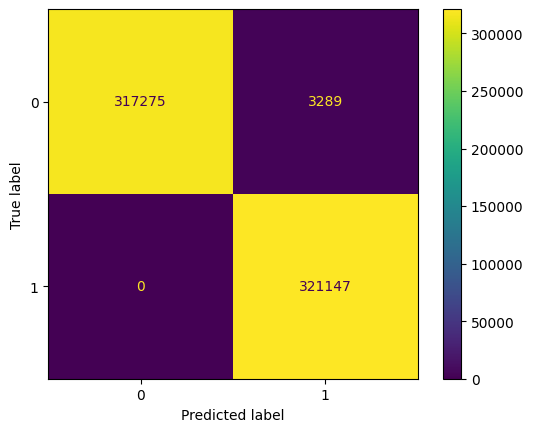

In [ ]:
# Create the confusion matrix
cm = confusion_matrix(y_test_over, y_pred_over)
ConfusionMatrixDisplay(confusion_matrix = cm).plot();

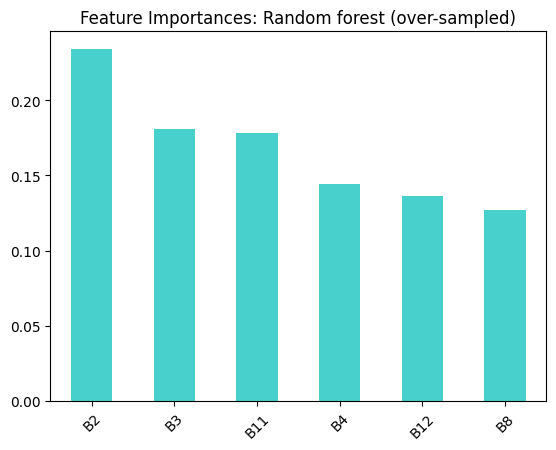

In [ ]:
# Plot the feature importances
feature_importances = pd.Series(rf_over.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', color='mediumturquoise')
plt.title('Feature Importances: Random forest (over-sampled)')
plt.xticks(rotation=45)
plt.show()

###XGBoost over-sampling

In [ ]:
#Train model
xgb_over = XGBClassifier(random_state = 42)
xgb_over.fit(X_train_over, y_train_over)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [ ]:
#Evaluate
y_pred_xgb_over = xgb_over.predict(X_test_over)
print(classification_report(y_test_over, y_pred_xgb_over))

              precision    recall  f1-score   support

         0.0       0.85      0.80      0.82    320564
         1.0       0.81      0.85      0.83    321147

    accuracy                           0.83    641711
   macro avg       0.83      0.83      0.83    641711
weighted avg       0.83      0.83      0.83    641711



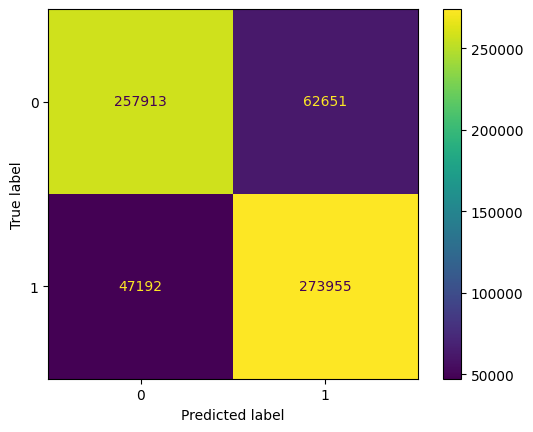

In [ ]:
# Create the confusion matrix
cm = confusion_matrix(y_test_over, y_pred_xgb_over)
ConfusionMatrixDisplay(confusion_matrix = cm).plot();

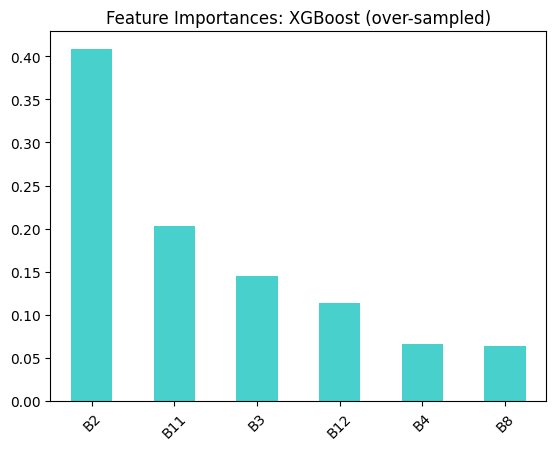

In [ ]:
# Plot the feature importances
feature_importances = pd.Series(xgb_over.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', color='mediumturquoise')
plt.title('Feature Importances: XGBoost (over-sampled)')
plt.xticks(rotation=45)
plt.show()

##Urban over-sampled

###Loading urban over-sampled data

In [ ]:
#Labeled dataset
df_urban_train_over = pd.read_csv('/content/gdrive/MyDrive/mds_thesis/6_split_data/df_urban_train_over.csv')
df_urban_test_over = pd.read_csv('/content/gdrive/MyDrive/mds_thesis/6_split_data/df_urban_test_over.csv')

In [ ]:
print(df_urban_train_over.shape)
print(df_urban_test_over.shape)

(993387, 10)
(248347, 10)


In [ ]:
df_train_over2 = df_urban_train_over[['B2', 'B3', 'B4', 'B8', 'B11', 'B12',  'building']]
df_test_over2 = df_urban_test_over[['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'building']]

In [ ]:
#Convert to NumPy arrays
train_over_np = df_train_over2.to_numpy()
X_train_over, y_train_over = train_over_np[:, :-1], train_over_np[:, -1]

test_over_np = df_test_over2.to_numpy()
X_test_over, y_test_over = test_over_np[:, :-1], test_over_np[:, -1]

###Random forest urban over-sampled

In [ ]:
#Train model
rf_urban_over = RandomForestClassifier(random_state = 42)
rf_urban_over.fit(X_train_over, y_train_over)

RandomForestClassifier(random_state=42)

In [ ]:
#Evaluate
y_urban_pred_over = rf_urban_over.predict(X_test_over)
print(classification_report(y_test_over, y_urban_pred_over))

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99    124004
         1.0       0.97      1.00      0.99    124343

    accuracy                           0.99    248347
   macro avg       0.99      0.99      0.99    248347
weighted avg       0.99      0.99      0.99    248347



##Semi-urban over-sampled

###Loading semi-urban over-sampled data

In [ ]:
#Labeled dataset
df_semi_urban_train_over = pd.read_csv('/content/gdrive/MyDrive/mds_thesis/6_split_data/df_semi_urban_train_over.csv')
df_semi_urban_test_over = pd.read_csv('/content/gdrive/MyDrive/mds_thesis/6_split_data/df_semi_urban_test_over.csv')

In [ ]:
print(df_semi_urban_train_over.shape)
print(df_semi_urban_test_over.shape)

(1001488, 10)
(250372, 10)


In [ ]:
df_train_over2 = df_semi_urban_train_over[['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'building']]
df_test_over2 = df_semi_urban_test_over[['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'building']]

#Convert to NumPy arrays
train_over_np = df_train_over2.to_numpy()
X_train_over, y_train_over = train_over_np[:, :-1], train_over_np[:, -1]

test_over_np = df_test_over2.to_numpy()
X_test_over, y_test_over = test_over_np[:, :-1], test_over_np[:, -1]

print(X_train_over.shape)
print(y_test_over.shape)

(1001488, 6)
(250372,)


###Random forest semi-urban over-sampled

In [ ]:
#Train model
rf_semi_urban_over = RandomForestClassifier(random_state = 42)
rf_semi_urban_over.fit(X_train_over, y_train_over)

RandomForestClassifier(random_state=42)

In [ ]:
#Evaluate
y_semi_urban_pred_over = rf_semi_urban_over.predict(X_test_over)
print(classification_report(y_test_over, y_semi_urban_pred_over))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    124978
         1.0       1.00      1.00      1.00    125394

    accuracy                           1.00    250372
   macro avg       1.00      1.00      1.00    250372
weighted avg       1.00      1.00      1.00    250372



##Rural over-sampled

###Loading rural over-sampled data

In [ ]:
#Labeled dataset
df_rural_train_over = pd.read_csv('/content/gdrive/MyDrive/mds_thesis/6_split_data/df_rural_train_over.csv')
df_rural_test_over = pd.read_csv('/content/gdrive/MyDrive/mds_thesis/6_split_data/df_rural_test_over.csv')

In [ ]:
print(df_rural_train_over.shape)
print(df_rural_test_over.shape)

(571966, 10)
(142992, 10)


In [ ]:
df_train_over2 = df_rural_train_over[['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'building']]
df_test_over2 = df_rural_test_over[['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'building']]

#Convert to NumPy arrays
train_over_np = df_train_over2.to_numpy()
X_train_over, y_train_over = train_over_np[:, :-1], train_over_np[:, -1]

test_over_np = df_test_over2.to_numpy()
X_test_over, y_test_over = test_over_np[:, :-1], test_over_np[:, -1]

print(X_train_over.shape)
print(y_test_over.shape)

(571966, 6)
(142992,)


###Random forest rural over-sampled

In [ ]:
#Train model
rf_rural_over = RandomForestClassifier(random_state = 42)
rf_rural_over.fit(X_train_over, y_train_over)

RandomForestClassifier(random_state=42)

In [ ]:
#Evaluate
y_rural_pred_over = rf_rural_over.predict(X_test_over)
print(classification_report(y_test_over, y_rural_pred_over))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     71489
         1.0       1.00      1.00      1.00     71503

    accuracy                           1.00    142992
   macro avg       1.00      1.00      1.00    142992
weighted avg       1.00      1.00      1.00    142992



##ADASYN

In [ ]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN

In [ ]:
# Split the dataset
X = df[['B2', 'B3', 'B4', 'B8', 'B11', 'B12']]
y = df['building']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
# Rescale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Apply ADASYN
adasyn = ADASYN(random_state=42)
X_train_balanced, y_train_balanced = adasyn.fit_resample(X_train_scaled, y_train)

# Combine the original and synthetic data
X_train_ada = np.concatenate((X_train_scaled, X_train_balanced))
y_train_ada = np.concatenate((y_train, y_train_balanced))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_ada = RandomForestClassifier(random_state = 42)
rf_ada.fit(X_train_ada, y_train_ada)

###Bagging random forest

In [ ]:
from sklearn.ensemble import BaggingClassifier

In [ ]:
# Initialize a base random forest model
rf = RandomForestClassifier(n_estimators=100, max_depth=5)

# Initialize a bagging classifier
bagging_rf = BaggingClassifier(base_estimator = rf, n_estimators=10)

# Fit the bagging classifier to the training data
bagging_rf.fit(X_train_over, y_train_over)

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


BaggingClassifier(base_estimator=RandomForestClassifier(max_depth=5))

In [ ]:
# Evaluate the bagging classifier on the test data
bagging_rf.score(X_test, y_test)

0.7980323088552077

###Boosting random forest

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
# Initialize an AdaBoost classifier
boosting_rf = AdaBoostClassifier(base_estimator = rf, n_estimators=10)

# Fit the AdaBoost classifier to the training data
boosting_rf.fit(X_train_over, y_train_over)

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostClassifier(base_estimator=RandomForestClassifier(max_depth=5),
                   n_estimators=10)

In [ ]:
# Evaluate the AdaBoost classifier on the test data
boosting_rf.score(X_test, y_test)

0.8035684942352566

##Saving models

In [ ]:
import pickle

In [ ]:
#rf_bagging
with open('rf_bagging', 'wb') as f:
  pickle.dump(bagging_rf, f)

In [ ]:
'''
#nb_std
with open('nb_std', 'wb') as f:
    pickle.dump(nb_std, f)

#hyp_nb_std
with open('hyp_nb_std', 'wb') as f:
    pickle.dump(hyp_nb, f)

#lr_std
with open('lr_std', 'wb') as f:
    pickle.dump(lr_std, f)

#hyper_best_rf
with open('hyper_best_rf', 'wb') as f:
    pickle.dump(best_rf, f)

#rf_std
with open('rf_std', 'wb') as f:
  pickle.dump(rf_std, f)

#xgb_std
with open('xgb_std', 'wb') as f:
  pickle.dump(xgb_std, f)

#rf_wgt
with open('rf_wgt', 'wb') as f:
  pickle.dump(rf_wgt, f)

#knn_std
with open('knn_std', 'wb') as f:
  pickle.dump(knn_std, f)

#rf_over
with open('rf_over', 'wb') as f:
  pickle.dump(rf_over, f)

#xgb_over
with open('xgb_over', 'wb') as f:
  pickle.dump(xgb_over, f)

#rf_urban_over
with open('rf_urban_over', 'wb') as f:
    pickle.dump(rf_urban_over, f)

#rf_semi_urban_over
with open('rf_semi_urban_over', 'wb') as f:
    pickle.dump(rf_semi_urban_over, f)

#rf_rural_over
with open('rf_rural_over', 'wb') as f:
    pickle.dump(rf_rural_over, f)

#rf_ada
with open('rf_ada', 'wb') as f:
  pickle.dump(rf_ada, f)

#rf_bagging
with open('rf_bagging', 'wb') as f:
  pickle.dump(bagging_rf, f)

#rf_boosting
with open('rf_boosting', 'wb') as f:
  pickle.dump(boosting_rf, f)

'''

In [ ]:
knn_std = pickle.load(open('/content/gdrive/MyDrive/mds_thesis/8_saved_models/knn_std', 'rb'))